In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Dropout


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('/content/test_without_label.csv')
val = pd.read_csv('val.csv')

In [ ]:
train.head()

,Date,Price,Open,High,Low,Vol.
0,2003-12-31,1.04,1.05,1.06,1.03,6.11M
1,2004-01-04,1.04,1.05,1.05,1.02,3.41M
2,2004-01-05,1.04,1.03,1.05,1.02,4.41M
3,2004-01-06,1.05,1.04,1.07,1.03,16.22M
4,2004-01-08,1.05,1.09,1.09,1.04,12.94M


In [ ]:
print(train.info())
print(test.info())
print(val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3640 non-null   object 
 1   Price   3640 non-null   float64
 2   Open    3640 non-null   float64
 3   High    3640 non-null   float64
 4   Low     3640 non-null   float64
 5   Vol.    3640 non-null   object 
dtypes: float64(4), object(2)
memory usage: 170.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      728 non-null    int64  
 1   Date    728 non-null    object 
 2   Open    728 non-null    float64
 3   High    728 non-null    float64
 4   Low     728 non-null    float64
 5   Vol.    728 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 34.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729

In [ ]:
# convert date to DataTime
for df in [train, val, test]:
    df['Date'] = pd.to_datetime(df['Date'])
train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3640 non-null   datetime64[ns]
 1   Price   3640 non-null   float64       
 2   Open    3640 non-null   float64       
 3   High    3640 non-null   float64       
 4   Low     3640 non-null   float64       
 5   Vol.    3640 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 170.8+ KB


In [ ]:
# clean the data
#1) remove M and K frm the volumn column

def clean_volume(vol):
    if isinstance(vol, str):
        vol = vol.replace(',', '').strip()
        if vol.endswith('M'):
            return float(vol[:-1]) * 1_000_000
        elif vol.endswith('K'):
            return float(vol[:-1]) * 1_000
        else:
            return float(vol)
    return vol

# Apply to your DataFrames
train['Vol.'] = train['Vol.'].apply(clean_volume).astype(float)
val['Vol.'] = val['Vol.'].apply(clean_volume).astype(float)
test['Vol.'] = test['Vol.'].apply(clean_volume).astype(float)
train.head()

print(val['Vol.'].dtype)


float64


In [ ]:
def add_technical_features_without_target(df):




    # Adding more features like the open-close diff and price range
    df['price_range'] = df['High'] - df['Low']
    df['average_price'] = (df['High'] + df['Low']) / 2
    df['open_close_diff'] = df['Open'] - df['average_price']


    return df

# Apply feature engineering on train, val, and test sets
train = add_technical_features_without_target(train)
val = add_technical_features_without_target(val)
test = add_technical_features_without_target(test)

# Drop rows with NaN values after feature creation



In [ ]:

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Combine only the training data for fitting the scaler
scaler = MinMaxScaler()
#num_cols = ['Open', 'High', 'Low', 'Vol.','price_range', 'average_price', 'open_close_diff']
num_cols = ['Open', 'High', 'Low', 'Vol.', 'price_range', 'average_price', 'open_close_diff']
target_col = ['Price']

# Fit scaler only on training data (to avoid data leakage)
scaler.fit(train[num_cols])
target_scaler = MinMaxScaler()
target_scaler.fit(train[target_col])
# Scale train, val, test using the fitted scaler
train_scaled = train.copy()
val_scaled = val.copy()
test_scaled = test.copy()

train_scaled[num_cols] = scaler.fit_transform(train[num_cols])
val_scaled[num_cols] = scaler.transform(val[num_cols])
test_scaled[num_cols] = scaler.transform(test[num_cols])

train_scaled['Price'] = target_scaler.transform(train[['Price']])  # Scale target column (Price)
val_scaled['Price'] = target_scaler.transform(val[['Price']])


# Save test IDs for output
test_ids = test['ID'].values


In [ ]:
def create_train_sequences(data, window_size=30, target_col='Price'):
    X, y = [], []
    feature_cols = [col for col in data.columns if col not in ['Date', 'ID', target_col]]

    for i in range(len(data) - window_size - 1):
        X.append(data[feature_cols].iloc[i:i + window_size].values)
        y.append(data[target_col].iloc[i + window_size])

    return np.array(X), np.array(y)

def create_test_sequences(data, window_size=30):
    X = []
    feature_cols = [col for col in data.columns if col not in ['Date', 'ID', 'Price']]

    for i in range(len(data) - window_size):
        X.append(data[feature_cols].iloc[i:i + window_size].values)

    return np.array(X)


X_train, y_train = create_train_sequences(train_scaled)
X_val, y_val = create_train_sequences(val_scaled)
window_size=30
test_with_context = pd.concat([val_scaled.tail(window_size), test_scaled], ignore_index=True)

# Create test sequences with the full set (now includes all 729 IDs)
X_test_full = create_test_sequences(test_with_context)



In [ ]:


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD





# 1. Flatten X_train for linear regression
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))

# 2. Fit linear regression on training data
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train)

# 3. Predict and get residuals
y_train_pred = lin_reg.predict(X_train_flat)
train_residuals = y_train - y_train_pred

# 4. Define GRU model for residuals
gru_model =  tf.keras.models.Sequential([
    tf.keras.layers.GRU(256, activation=tf.nn.relu, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    tf.keras.layers.GRU(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

# optimizer = SGD(
#     learning_rate=0.01,   # Step size for weight updates
#     momentum=0.9,   # Helps accelerate gradients in the right direction
#     decay=1e-6,           # Reduces the learning rate over time
#     nesterov=True         # Nesterov momentum for better convergence
# )
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

gru_model.compile(optimizer=optimizer, loss='mse')









/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import necessary classes

# 5. Train GRU on residuals
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]
history = gru_model.fit(X_train, train_residuals, epochs=20, batch_size=32, validation_data=(X_val, y_val - lin_reg.predict(X_val_flat)))

# 6. Inference
X_test_flat = X_test_full.reshape((X_test_full.shape[0], -1))
linear_pred = lin_reg.predict(X_test_flat)
gru_pred = gru_model.predict(X_test_full).reshape(-1)

final_pred = linear_pred + gru_pred

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - loss: 8.2249e-05 - val_loss: 2.0780e-04
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - loss: 3.7477e-05 - val_loss: 2.0568e-04
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 3.5998e-05 - val_loss: 2.0618e-04
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - loss: 3.7636e-05 - val_loss: 2.0663e-04
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - loss: 3.5769e-05 - val_loss: 2.0644e-04
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - loss: 3.9192e-05 - val_loss: 2.0734e-04
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - loss: 3.5110e-05 - val_loss: 2.0648e-04
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - loss: 3.6005e-05 - val_loss: 2.0815e-04
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - loss: 3.7909e-05 - val_loss: 2.0592e-04
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - loss: 3.4280e-05 - val_loss: 2.0616e-04
Epoch 11/20
113/113 ━━━━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


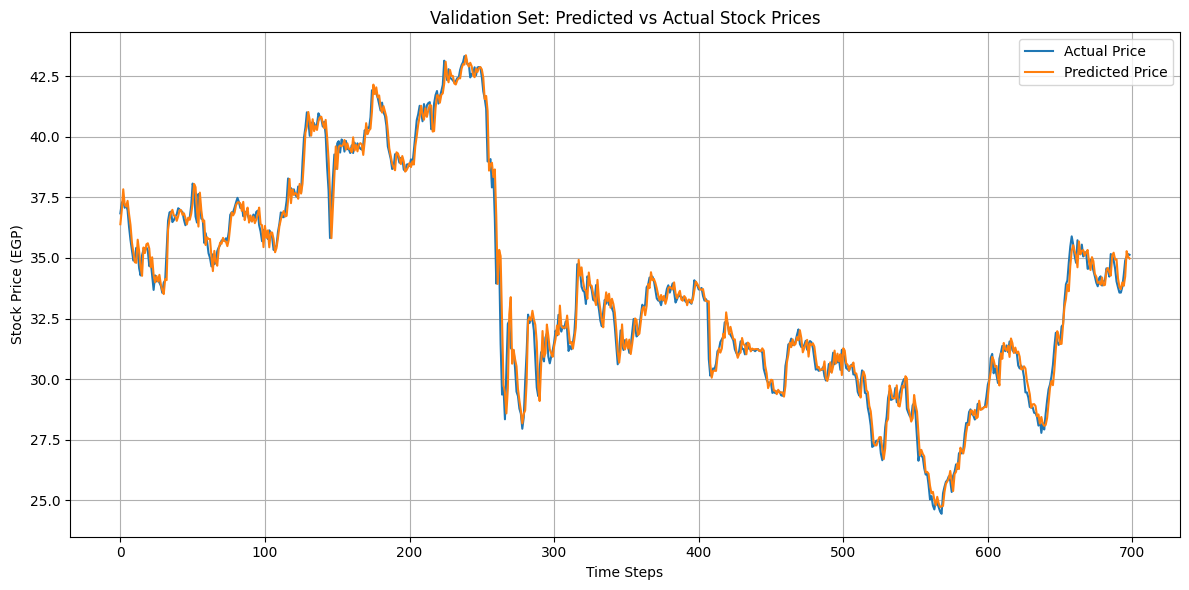

In [ ]:

# 6. Inference
linear_pred = lin_reg.predict(X_test_flat)
gru_pred = gru_model.predict(X_test_full).reshape(-1)
final_pred = linear_pred + gru_pred

# 7. Validation predictions
val_gru_pred = gru_model.predict(X_val).reshape(-1)
val_linear_pred = lin_reg.predict(X_val_flat)
val_final_pred = val_linear_pred + val_gru_pred

# 8. Inverse transform if needed
val_final_pred_inverse = target_scaler.inverse_transform(val_final_pred.reshape(-1, 1))
y_val_inverse = target_scaler.inverse_transform(y_val.reshape(-1, 1))

# 9. Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse, label='Actual Price')
plt.plot(val_final_pred_inverse, label='Predicted Price')
plt.title('Validation Set: Predicted vs Actual Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price (EGP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Inverse transform for fair comparison (if scaled)
y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_inv = target_scaler.inverse_transform((lin_reg.predict(X_train_flat) + gru_model.predict(X_train).reshape(-1)).reshape(-1, 1))

y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_val_pred_inv = val_final_pred_inverse

print("Train RMSE:", np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv)))
print("Val RMSE:", np.sqrt(mean_squared_error(y_val_inv, y_val_pred_inv)))


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
Train RMSE: 0.2203237296395344
Val RMSE: 0.530077023811518


In [ ]:
import pandas as pd
final_pred2 =target_scaler.inverse_transform(final_pred.reshape(-1, 1))
# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ID': test['ID'].values[:len(final_pred2)],
    'Price': final_pred2.flatten()
})

# Save to CSV
submission_df.to_csv('prediction11.csv', index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
